In [1]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
# assert pyro.__version__.startswith('1.5.0')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

True function is linear and weight is: -0.7393 and true bias is -8.536, true sigma is 0.4
AAAA


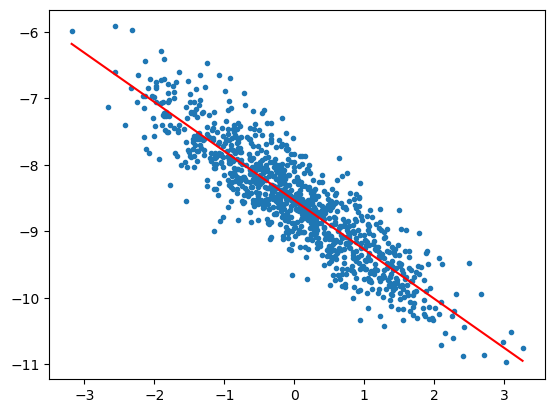

In [145]:
#toy data

def reverse_indices(source_indices, N):
    total_idices = torch.linspace(0,N-1, N).to(torch.int64)
    total_idices, unique_idx = torch.cat((total_idices, source_indices)).unique(return_counts= True)
    reversed_idices = total_idices[unique_idx == 1]
    return reversed_idices


def generate_data(N=1000, noise_variation = 4, weight_std=1, bias_std=10, sine = True, categories = True, 
                  category_2_proportion=0.2, category_2_noise_variation = 8):
    #generating bias
    b = torch.distributions.Normal(0,bias_std).sample()
    #generating data points
    
    # if sine function is the basis
    if sine:
        X = torch.linspace(2,2.2*3.14, N)
        Y = torch.sin(X) + b
    # if linear function is the basis
    else:
        w = torch.distributions.Normal(0,weight_std).sample()
        X = torch.randn(N)
        Y = w * X + b
    
    # if introducing a categorical variable
    if categories :
        # get the number of points
        category_threshold = int(torch.clamp(torch.tensor(category_2_proportion), 0, 1) * N)
        # permute teh indices
        indices = torch.randperm(N)
    
    print(f"{'True function is sine' if sine else f'True function is linear and weight is: {w:.4}'} and true bias is {b:.4}, true sigma is {noise_variation}")
    
    #adding noise
    if categories:
        Y[indices[category_threshold:]] += torch.distributions.Normal(0,noise_variation).sample(Y[indices[category_threshold:]].shape)
        Y[indices[:category_threshold]] += torch.distributions.Normal(0,category_2_noise_variation).sample(Y[indices[:category_threshold]].shape)
    else:
        Y += torch.distributions.Normal(0,noise_variation).sample(Y.shape)
    X = X.unsqueeze(1)
    return_dict = {"predictors":X,"target":Y, "bias":b}
    if not sine:
          return_dict["weight"]=w
    if categories:
          category_dict = {"category_threshold":category_threshold, "indices":indices}
          return_dict.update(category_dict)
    return return_dict

def plot_data(X,Y,w = None,b = None, sine= True, category_threshold = 10, indices = None):
    if indices is not None:
          plt.scatter(X[indices[category_threshold:]].numpy(), Y[indices[category_threshold:]].numpy(), marker=".", color = 'blue')
          plt.scatter(X[indices[:category_threshold]].numpy(), Y[indices[:category_threshold]].numpy(), marker=".", color = 'red')
    else:
          plt.scatter(X.numpy(), Y.numpy(), marker=".")
    dummy_predictors = torch.linspace(X.min(), X.max(), steps=4)
    if sine:
        dummy_targets =  np.sin(dummy_predictors) + b
    else:
        dummy_targets = w * dummy_predictors + b
    plt.plot(dummy_predictors.numpy(), dummy_targets.numpy(), color='r')

N=1000
sine = False
categories = False
noise_variation = 0.4
noise_variation_2 = 0.99
data = generate_data(N=N, noise_variation = noise_variation, sine=sine,categories=categories , category_2_noise_variation=noise_variation_2)
X,Y, b=  data["predictors"], data["target"],data["bias"]

w = data["weight"] if not sine else None
if categories:
    category_threshold ,indices = data["category_threshold"], data["indices"]
else:
    indices= None
plot_data(X,Y,w,b, sine=sine, indices=indices, category_threshold=category_threshold)
        
# if categ

# torch.manual_seed(0)
def split_train_target_test_covariate_shift(X,Y, shift_point = 5):
    train_idx = (X<shift_point).nonzero()[:,0]
    # split along a covariate
    idx=(X>shift_point).nonzero()[:,0]
    # half of the test set will be unseen
    print(X.shape)
    test_size = idx.shape[0]//2
    # sample it randomely
    test_idx_of_idx = torch.multinomial(torch.ones_like(idx, dtype=torch.float16), test_size)
    
    # now extract the reverse of the test set as target set
    target_idx_of_idx= reverse_indices(test_idx_of_idx, idx.shape[0])
    
    # now get indices in terms of original data
    target_idx, test_idx = idx[target_idx_of_idx], idx[test_idx_of_idx]
    
    target_X, target_Y =X[target_idx], Y[target_idx],
    test_X, test_Y = X[test_idx], Y[test_idx]
    train_X, train_Y = X[train_idx], Y[train_idx]
    return train_X, train_Y, target_X, target_Y, test_X, test_Y

if sine:  
    train_X, train_Y, target_X, target_Y, test_X, test_Y = split_train_target_test_covariate_shift(X,Y)




Two different aspects I can vary for utility in case of categorical utility:
1. Number of points of one type or another
2. Variance of points of one type or the other 

todo: 
1. Introduce categorical variable
2. Generate dataset where points of one type have much higher variance than of the other type
3. Check if introducing LC increases the variance of predictive posterior

In [35]:
# africa data
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

In [270]:
is_africa = False
data_x = x_data if is_africa else X
data_y = y_data if is_africa else Y

In [39]:
from pyro.nn import PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal

class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean
    


In [44]:
def utility_regulariser(guide, x_target, y_target = None):
    args = (x_target, y_target)
    kwargs = {}
    reg_loss = 0.0
    # sample guide
    guide_trace = pyro.poutine.trace(guide).get_trace(*args, **kwargs)
#     print(*guide_trace)

    return reg_loss

In [53]:
pyro.clear_param_store()
model = BayesianRegression(train_X.shape[1], 1)
guide = AutoDiagonalNormal(model)

model_and_guide_args = (train_X, train_Y)
# to populate param_store
guide(*model_and_guide_args)

# define optimizer and loss function
optimizer = torch.optim.Adam(guide.parameters(), **{"lr": 0.01, "betas": (0.90, 0.999)})
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss


# compute loss
num_iters = 1000
elbo = []
for i in range(num_iters):
    loss = loss_fn(model, guide, *model_and_guide_args) + utility_regulariser(guide, target_X, target_Y)
    loss.backward()
    # take a step and zero the parameter gradients
    optimizer.step()
    optimizer.zero_grad()
    
    elbo.append(loss.item()/ len(train_X))
    if i % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (i + 1, loss.item() / len(train_X)))
print(f"{elbo[-1]:.2f}")


# todo do heldout log likelihood on , test_X, test_Y
test_args = (test_X, test_Y)
with torch.no_grad():
    loss = loss_fn(model, guide, *test_args)
print(loss/len(test_Y))

[iteration 0001] loss: 4.3235
[iteration 0101] loss: 3.1355
[iteration 0201] loss: 2.6918
[iteration 0301] loss: 2.4132
[iteration 0401] loss: 2.2812
[iteration 0501] loss: 2.1975
[iteration 0601] loss: 2.1423
[iteration 0701] loss: 2.0610
[iteration 0801] loss: 1.9239
[iteration 0901] loss: 1.7672
1.57
tensor(1.5618)


In [49]:
model = BayesianRegression(train_X.shape[1], 1)
guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.01, "betas": (0.90, 0.999)})
svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.Trace_ELBO())
num_iterations=1500
# print(data_x.shape, data_y.shape)
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(*model_and_guide_args)
#     print(*pyro.get_param_store().items())
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(train_X)))

[iteration 0001] loss: 5.1073
[iteration 0101] loss: 3.3079
[iteration 0201] loss: 2.9343
[iteration 0301] loss: 2.6229
[iteration 0401] loss: 2.4489
[iteration 0501] loss: 2.3777
[iteration 0601] loss: 2.3434
[iteration 0701] loss: 2.2500
[iteration 0801] loss: 2.2039
[iteration 0901] loss: 2.1039
[iteration 1001] loss: 2.0234
[iteration 1101] loss: 1.9275
[iteration 1201] loss: 1.7270
[iteration 1301] loss: 1.5218
[iteration 1401] loss: 1.2183


In [189]:
from pyro.infer import SVI, Trace_ELBO

model = BayesianRegression(data_x.shape[1], 1)
guide = AutoDiagonalNormal(model)

adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())
num_iterations=1500
print(data_x.shape, data_y.shape)
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(data_x, data_y)
    print(*pyro.get_param_store().items())
    break
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))
print(*pyro.get_param_store().items())

torch.Size([100, 1]) torch.Size([100])
('AutoDiagonalNormal.loc', Parameter containing:
tensor([-0.0394, -0.2764,  2.2473], requires_grad=True)) ('AutoDiagonalNormal.scale', tensor([0.0970, 0.1030, 0.0970], grad_fn=<AddBackward0>))
('AutoDiagonalNormal.loc', Parameter containing:
tensor([-0.0394, -0.2764,  2.2473], requires_grad=True)) ('AutoDiagonalNormal.scale', tensor([0.0970, 0.1030, 0.0970], grad_fn=<AddBackward0>))


In [70]:
# MLE 
# Regression model
linear_reg_model = PyroModule[nn.Linear](data_x.shape[1], 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(data_x).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, data_y)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))


# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

[iteration 0050] loss: 16.4519
[iteration 0100] loss: 16.3219
[iteration 0150] loss: 16.3220
[iteration 0200] loss: 16.3219
[iteration 0250] loss: 16.3219
[iteration 0300] loss: 16.3219
[iteration 0350] loss: 16.3219
[iteration 0400] loss: 16.3219
[iteration 0450] loss: 16.3219
[iteration 0500] loss: 16.3219
[iteration 0550] loss: 16.3219
[iteration 0600] loss: 16.3219
[iteration 0650] loss: 16.3219
[iteration 0700] loss: 16.3219
[iteration 0750] loss: 16.3219
[iteration 0800] loss: 16.3219
[iteration 0850] loss: 16.3219
[iteration 0900] loss: 16.3219
[iteration 0950] loss: 16.3219
[iteration 1000] loss: 16.3219
[iteration 1050] loss: 16.3219
[iteration 1100] loss: 16.3219
[iteration 1150] loss: 16.3219
[iteration 1200] loss: 16.3219
[iteration 1250] loss: 16.3219
[iteration 1300] loss: 16.3219
[iteration 1350] loss: 16.3219
[iteration 1400] loss: 16.3219
[iteration 1450] loss: 16.3219
[iteration 1500] loss: 16.3219
Learned parameters:
weight [[0.6483629]]
bias [2.6802158]


In [55]:
try:
    print("MLE")
    for name, param in linear_reg_model.named_parameters():
        print(name, param.data.numpy())
except:
    print("Didn't run MLE")
print("\n SVI")
for name, param in pyro.get_param_store().items():
    print(name, param.data.numpy())
print("\n Quantiles")
for name, param in guide.quantiles([0.05, 0.5, 0.95]).items():
    print(name, param)

MLE
Didn't run MLE

 SVI
AutoDiagonalNormal.loc [-2.0291893   0.38841105  9.054892  ]
AutoDiagonalNormal.scale [0.03993865 0.02445831 0.06581175]

 Quantiles
sigma [tensor(1.0960, grad_fn=<AddBackward0>), tensor(1.1617, grad_fn=<AddBackward0>), tensor(1.2309, grad_fn=<AddBackward0>)]
linear.weight [tensor([[0.3482]], grad_fn=<ViewBackward>), tensor([[0.3884]], grad_fn=<ViewBackward>), tensor([[0.4286]], grad_fn=<ViewBackward>)]
linear.bias [tensor([8.9466], grad_fn=<ViewBackward>), tensor([9.0549], grad_fn=<ViewBackward>), tensor([9.1631], grad_fn=<ViewBackward>)]


In [76]:
from pyro.infer import Predictive


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(data_x)
pred_summary = summary(samples)

In [84]:
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean


guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

svi = SVI(model,
          guide,
          pyro.optim.Adam({"lr": .01}),
          loss=Trace_ELBO())

# is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
for i in range(5000):
    elbo = svi.step(data_x, data_y)
    if i % 500 == 0:
        print("Elbo loss: {}".format(elbo))

Elbo loss: 722.2728531956673
Elbo loss: 222.1264785528183
Elbo loss: 69.69957780838013
Elbo loss: 69.61809635162354
Elbo loss: 71.03992891311646
Elbo loss: 69.5084183216095
Elbo loss: 69.46130359172821
Elbo loss: 70.01934659481049
Elbo loss: 71.50209403038025
Elbo loss: 69.5404531955719
